In [154]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import statsmodels.tsa.api as smt
import plotly.express as px

import seaborn as sns

***

### Загрузка данных

In [7]:
df = pd.read_csv('../data/Winter negative temperature sum in deg C 1781  1988.csv', index_col=0)
df['t'] = pd.to_datetime({'year': df.index.values + 1780,
                          'month': 1,
                          'day': 1})

df = df.set_index('t').sort_index()

df.head()

,x
t,
1782-01-01,272.3
1783-01-01,207.8
1784-01-01,545.7
1785-01-01,557.5
1786-01-01,260.6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208 entries, 1 to 208
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   x       208 non-null    float64       
 1   t       207 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.9 KB


***

### Предсказание временного ряда с помощью деревьев

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [12]:
# Смещаем данные на 1 лаг
n_vars = 1 if type(df) is list else df.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(df.shift(i))
for i in range(0, 1):
    cols.append(df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [14]:
def decision_tree_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

def random_forest_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

#### Случайный лес

In [28]:
y_pred = list()
size = int(len(list_for_forecast) * 0.66)

train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    y_pred.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], y_pred)
print("Random Forest error: ", error)

Random Forest error:  132.1268971070875


In [29]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], y_pred)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], y_pred))
print("MAE:", mean_absolute_error(test[:, -1], y_pred))
print("R2: ", r2_score(test[:, -1], y_pred))

Random Forest metrics: 
RMSE: 170.9329546871507
MAPE: 0.6555391643210727
MAE: 132.1268971070875
R2:  -0.5921348482575763


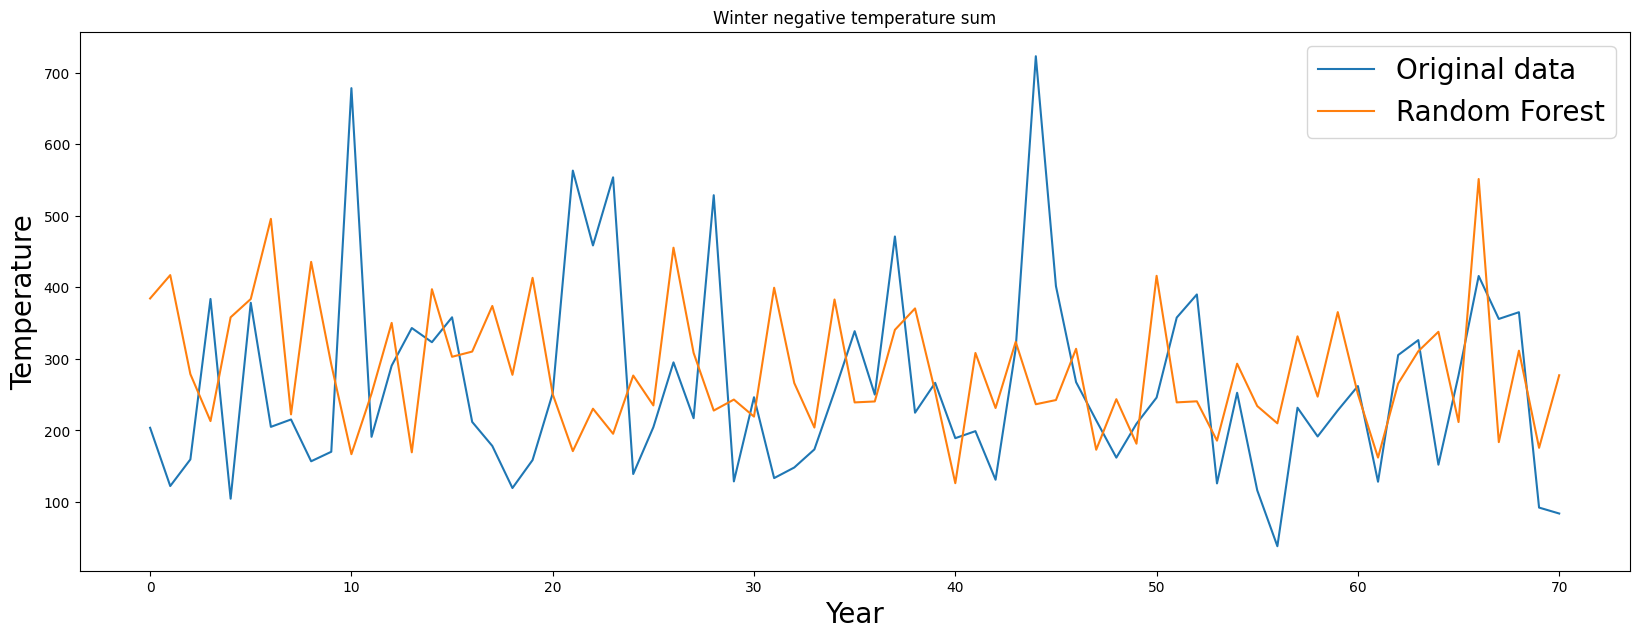

In [30]:
fig = plt.figure(figsize=(20, 7))
plt.plot(test[:, -1], label='Original data')
plt.plot(y_pred, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Winter negative temperature sum')
plt.ylabel('Temperature', fontsize="20")
plt.xlabel('Year', fontsize="20")
plt.show()

#### Дерево решений

In [23]:
y_pred_1 = list()
size = int(len(list_for_forecast) * 0.66)

train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    y_pred_1.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], y_pred_1)
print("Decision tree error: ", error)

Decision tree error:  156.73169014084505


In [27]:
print("Decision tree metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], y_pred_1)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], y_pred_1))
print("MAE:", mean_absolute_error(test[:, -1], y_pred_1))
print("R2: ", r2_score(test[:, -1], y_pred_1))

Decision tree metrics: 
RMSE: 204.91889231980895
MAPE: 0.716039588462501
MAE: 156.73169014084505
R2:  -1.2881908677053318


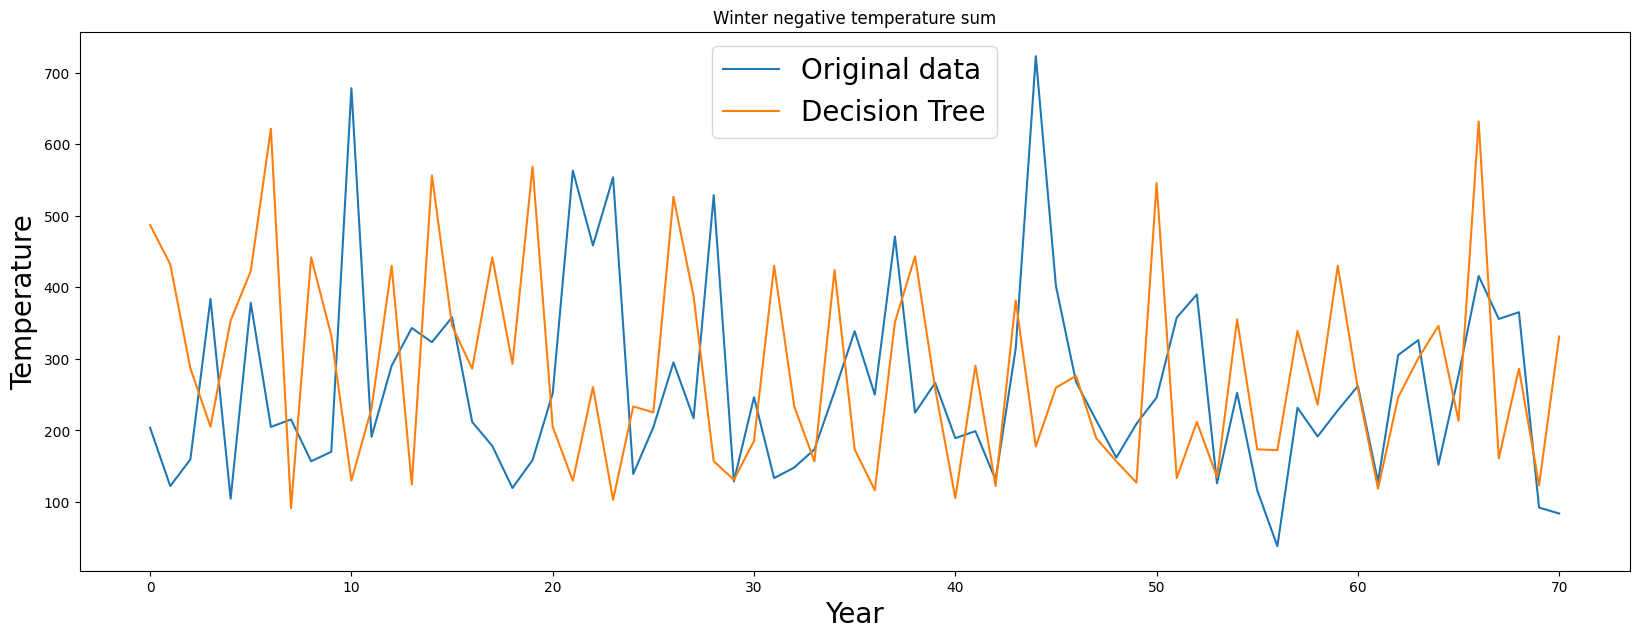

In [26]:
fig = plt.figure(figsize=(20, 7))
plt.plot(test[:, -1], label='Original data')
plt.plot(y_pred_1, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Winter negative temperature sum')
plt.ylabel('Temperature', fontsize="20")
plt.xlabel('Year', fontsize="20")
plt.show()

***

### Детекция аномалий с помощью isolated forest

In [31]:
from sklearn.ensemble import IsolationForest

In [125]:
dff = pd.read_csv('../data/Winter negative temperature sum in deg C 1781  1988.csv', index_col=0)
dff['t'] = pd.to_datetime({'year': dff.index.values + 1780,
                          'month': 1,
                          'day': 1})

dff

,x,t
1,272.3,1782-01-01
2,207.8,1783-01-01
3,545.7,1784-01-01
4,557.5,1785-01-01
5,260.6,1786-01-01
...,...,...
204,415.8,1985-01-01
205,355.8,1986-01-01
206,365.2,1987-01-01
207,92.2,1988-01-01


In [145]:
model = IsolationForest(contamination=0.009)
model.fit(dff[['x']])

IsolationForest(contamination=0.009)

In [146]:

dff['outliers'] = pd.Series(model.predict(dff[['x']])).apply(func=lambda x: 'yes' if (x == -1) else 'no')

In [147]:
dff.query('outliers=="yes"')

,x,t,outliers
48,351.4,1829-01-01,yes
181,314.2,1962-01-01,yes


<Axes: xlabel='t', ylabel='x'>

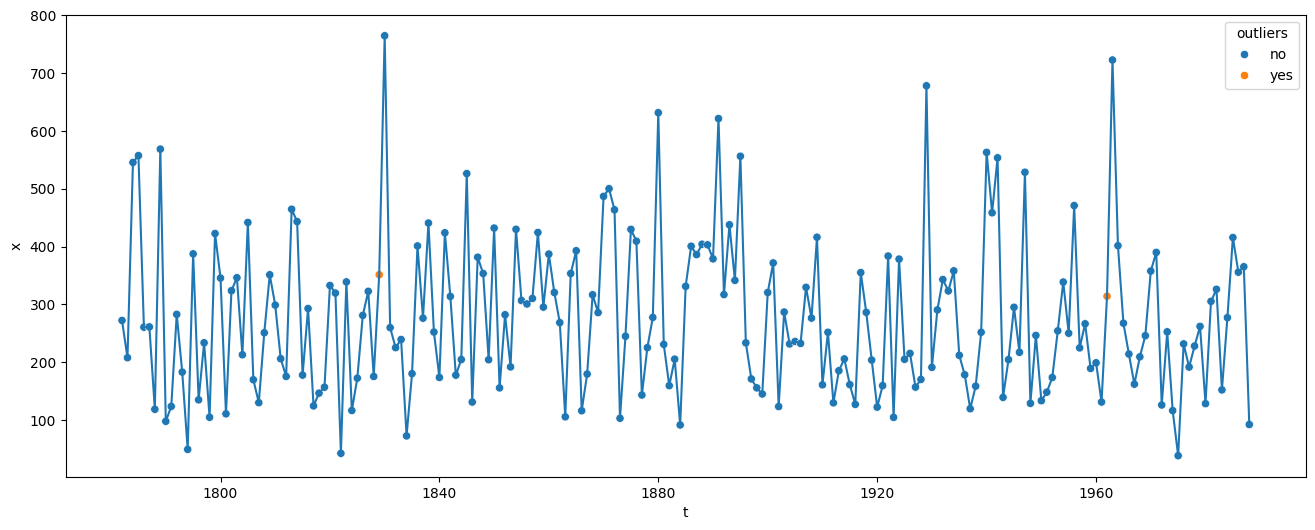

In [171]:
plt.figure(figsize=(16, 6))
plt.plot(dff.t, dff.x)
sns.scatterplot(dff, x='t', y='x', hue='outliers')